In [1]:
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score

from itertools import product

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from scipy.stats import mode
from sklearn.model_selection import cross_val_score

I pulled and cleaned a comprehensive dataset of colleges from this governmental database:
    
https://collegescorecard.ed.gov/data/

Let's read this dataset in:

In [2]:
df = pd.read_csv('data/schools.csv', index_col = 0)
print(df.shape)
df.head()

(6740, 46)


,name,ownership,ope6_id,state,size,accreditor,retention,branches,online_only,religious_affil,...,fafsa_sent,7_yr_repayment_completion,5_year_declining_balance,relig_y_n,accred_y_n,retention_listed_y_n,fac_salary_listed_y_n,7_yr_repayment_completion_y_n,5_year_declining_balance_y_n,for_profit
0,Alaska Bible College,2,8843,AK,27,Association for Bibical Higher Educaiton,0.333300,1,0,88.0,...,0.463652,0.699542,0.496850,1,1,1,1,0,0,0
1,Alaska Christian College,2,41386,AK,68,Association for Bibical Higher Educaiton,0.473700,1,0,37.0,...,0.463652,0.699542,0.496850,1,1,1,1,0,0,0
2,Ilisagvik College,1,34613,AK,109,Northwest Commission on Colleges and Universities,0.809500,1,0,-2.0,...,0.463652,0.699542,0.496850,0,1,1,1,0,0,0
3,Charter College-Anchorage,3,25769,AK,3256,Accrediting Council for Independent Colleges a...,0.703723,1,0,-2.0,...,0.310288,0.725806,0.417949,0,1,0,1,1,1,1
4,Alaska Career College,3,25410,AK,479,Accrediting Commission of Career Schools and C...,0.794100,1,0,-2.0,...,0.254237,0.556430,0.462520,0,1,1,1,1,1,1


We are going to use classification algorithms to try to predict for-profit or non-profit status. 

Some of the categories aren't applicable to what we want to do so let's consider the following columns only:


In [34]:
X = df[['size','retention','branches', 'online_only', 'under_investigation', 'most_common_degree', 'highest_degree',
       'faculty_salary', 'instructional_expenditure_per_fte',
       'tuition_revenue_per_fte', 'part_time_share',
       'age_entry', 'percent_dependent', 'first_generation', 'percent_black',
        'avg_family_income','ind_low_income', 'dep_low_income', 'loan_principal',
       'federal_loan_rate', 'students_with_any_loans',
       'pell_grant_debt', 'percent_pell_grant',
       'fafsa_sent', '7_yr_repayment_completion', '5_year_declining_balance',
       'relig_y_n', 'accred_y_n', 'retention_listed_y_n',
       'fac_salary_listed_y_n', '7_yr_repayment_completion_y_n',
       '5_year_declining_balance_y_n', 'for_profit']]
X.head()

,size,retention,branches,online_only,under_investigation,most_common_degree,highest_degree,faculty_salary,instructional_expenditure_per_fte,tuition_revenue_per_fte,...,fafsa_sent,7_yr_repayment_completion,5_year_declining_balance,relig_y_n,accred_y_n,retention_listed_y_n,fac_salary_listed_y_n,7_yr_repayment_completion_y_n,5_year_declining_balance_y_n,for_profit
0,27,0.333300,1,0,0,3,3,2201,9585,8132,...,0.463652,0.699542,0.496850,1,1,1,1,0,0,0
1,68,0.473700,1,0,0,1,2,5554,18174,12989,...,0.463652,0.699542,0.496850,1,1,1,1,0,0,0
2,109,0.809500,1,0,0,1,2,6054,38265,3587,...,0.463652,0.699542,0.496850,0,1,1,1,0,0,0
3,3256,0.703723,1,0,0,1,3,4004,2617,8755,...,0.310288,0.725806,0.417949,0,1,0,1,1,1,1
4,479,0.794100,1,0,0,1,2,3861,4178,11905,...,0.254237,0.556430,0.462520,0,1,1,1,1,1,1


Let's first use a method called [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html) to see which features have the most statistically significant relationships with profit status. The **lower** the p value, the **more** statistically significant:

In [42]:
y = X.pop('for_profit')

X_new = SelectKBest(chi2, k=2).fit(X, y)

features = []
for i, column in enumerate(X.columns):
    features.append((X_new.pvalues_[i], column))
features.sort()
print('chi2-value', 'feature')
features

chi2-value feature


[(0.0, 'avg_family_income'),
 (0.0, 'branches'),
 (0.0, 'faculty_salary'),
 (0.0, 'instructional_expenditure_per_fte'),
 (0.0, 'loan_principal'),
 (0.0, 'pell_grant_debt'),
 (0.0, 'size'),
 (0.0, 'tuition_revenue_per_fte'),
 (5.339096890496358e-283, 'highest_degree'),
 (2.3550018048916394e-222, 'most_common_degree'),
 (5.4025502611485345e-149, 'fac_salary_listed_y_n'),
 (8.240679129762035e-148, 'relig_y_n'),
 (5.293172158552389e-143, 'age_entry'),
 (1.4125160311605584e-48, 'percent_dependent'),
 (1.4293811306586728e-24, '5_year_declining_balance'),
 (1.3527931483012968e-21, 'federal_loan_rate'),
 (6.095800240149601e-17, 'percent_black'),
 (3.249757484509366e-15, 'fafsa_sent'),
 (2.3099399670297893e-10, '7_yr_repayment_completion'),
 (5.332261659651424e-09, 'first_generation'),
 (1.407934457452164e-08, 'part_time_share'),
 (1.516370320447573e-08, 'dep_low_income'),
 (5.389960032435474e-08, 'percent_pell_grant'),
 (2.9423628117768117e-06, 'students_with_any_loans'),
 (9.035892891499908e-

1.Based on the info above, what was intuitive? What was surprising? How big (or small) of an effect does accredition have on for-profit status? What might be some guesses as to why this is the case?

In [5]:
#insert 1
# Faculty salary and tuition revenue are intuitive. 
# It is surprising that average family income is significantly related to the profit status and also highest degree is not a big effect.
# Accredition has some effect on profit status which is around 0.825 because it evaluates institutions from a relavetily fair perspective which coudl be a reference.

2.Do a test/train split and give the testing accuracy error for logistic regression.

In [43]:
#insert 2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = LogisticRegression(multi_class = "auto", solver = 'lbfgs', max_iter=10000)
model.fit(X_train, y_train)

y_proba_LR = model.predict_proba(X_test)[:, 1]
print('accuracy:', model.score(X_test,y_test))

accuracy: 0.8976261127596439


3.Find the optimal number of nearest neighbors for KNN using grid search and then give the test accuracy. 

In [7]:
#insert 3
param_grid = {'n_neighbors': range(1, 20)}

model = GridSearchCV(KNeighborsClassifier(), 
                    param_grid, 
                    cv=3, 
                    scoring='accuracy')

model = model.fit(X_train, y_train)

print(model.best_params_, model.best_estimator_)

# k=9 is the opitimal one

{'n_neighbors': 9} KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')


In [8]:
model = model.best_estimator_

print(model.score(X_test, y_test))

0.890702274975272


4.Run a classification report and describe in detail what the terms mean in the context of your model.

In [9]:
#insert 4
print(classification_report(y, model.predict(X)))
# Precision: Out of all cases I predicted as non-profit, 0.92 was predicted as right; Out of all cases I predicted as profit,
#            0.91 was predicted as wright
# Recall: Out of all non-profit samples, 0.88 was actually non-profit; Out of all profit samples, 0.90 was actually profit.
# Support: 3835 samples in total were predicted accurately for non-profit and 2905 samples in total were predicted accturately for profit.
# Average: Out of all samples, 0.91 of the sample is predicted correctlt.

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      3835
           1       0.88      0.90      0.89      2905

    accuracy                           0.91      6740
   macro avg       0.90      0.90      0.90      6740
weighted avg       0.91      0.91      0.91      6740



5.Print a confusion matrix and describe what it means in your context.

In [10]:
#insert 5
confusion_matrix(y_test, model.predict(X_test))
# 128 in the non-profit are predicted incorrectly and 96 in the profit are predicted incorrectly.

array([[989, 128],
       [ 93, 812]])

6.Make a comparative ROC plot of the naive bayes, logistic, gradient boosting, and KNN classifiers.

In [67]:
#insert 6
def plot_roc(ytrue, yproba, model, title='some ROC curve'):
    auc = roc_auc_score(ytrue, yproba)
    fpr, tpr, thr = roc_curve(ytrue, yproba)
    plt.plot([0, 1], [0, 1], color='k', linestyle='--', linewidth=.4)
    plt.plot(fpr, tpr, label='{} auc={:.2f}%'.format(model, auc*100))
    plt.axis('equal')
    plt.xlim([-.02, 1.02])
    plt.ylim([-.02, 1.02])
    plt.ylabel('tpr')
    plt.xlabel('fpr')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)
y_proba_LR = model.predict_proba(X_test)[:, 1]

In [68]:
model = naive_bayes.GaussianNB()
model.fit(X_train, y_train)
y_proba_NB = model.predict_proba(X_test)[:, 1]

In [69]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
y_proba_GB = model.predict_proba(X_test)[:, 1]

In [70]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)
y_proba_KNN = model.predict_proba(X_test)[:, 1]

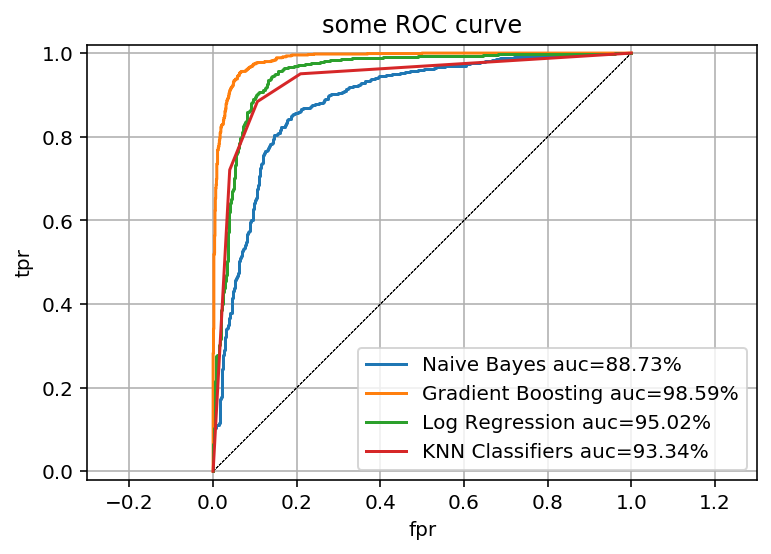

In [48]:
plot_roc(y_test, y_proba_NB, "Naive Bayes")
plot_roc(y_test, y_proba_GB, "Gradient Boosting")
plot_roc(y_test, y_proba_LR, "Log Regression")
plot_roc(y_test, y_proba_KNN,"KNN Classifiers")

7.Using the logarithmic regression model, plot a decision boundary between instructional_expenditure_per_fte and 5_year_declining_balance. Does it appear that for-profit status has a clear boundary based on these predictors?

(-2.941558886777559, 3.1784411132224464)

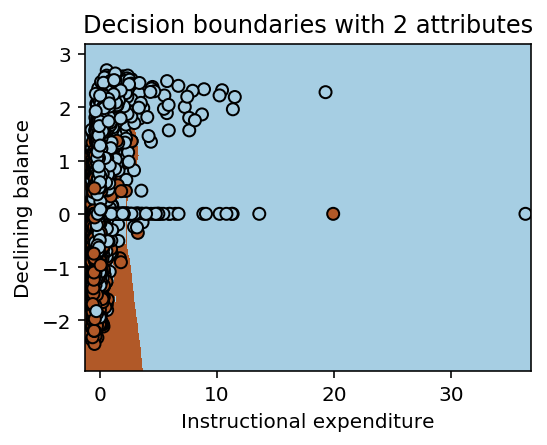

In [17]:
#insert 7
X = df[['instructional_expenditure_per_fte','5_year_declining_balance']]
X_scaler = StandardScaler()
X = X_scaler.fit_transform(X)
X = pd.DataFrame(X)

Q = X.values
h = .02  # meshsize
x_min, x_max = Q[:, 0].min() - .5, Q[:, 0].max() + .5 
y_min, y_max = Q[:, 1].min() - .5, Q[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
model.fit(X.iloc[:,:2], y)
Z = model.predict(np.c_[xx.ravel(), yy.ravel()]) # ravel() flattens the data

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(Q[:, 0], Q[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
plt.title('Decision boundaries with 2 attributes')
plt.xlabel('Instructional expenditure')
plt.ylabel('Declining balance')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

8.We have not covered random forests but they are a very popular type of classifier. It is very good practice in reading the docs to get a new classifier working. Read [this](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and then apply the RandomForestClassifier().

In [71]:
#insert 8
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_proba_Forest = model.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


9.Support vector machines are another type of classifier. Read the docs [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) and then try implementing that one.

In [62]:
#insert 9
X = df[['size','retention','branches', 'online_only', 'under_investigation', 'most_common_degree', 'highest_degree',
       'faculty_salary', 'instructional_expenditure_per_fte',
       'tuition_revenue_per_fte', 'part_time_share',
       'age_entry', 'percent_dependent', 'first_generation', 'percent_black',
        'avg_family_income','ind_low_income', 'dep_low_income', 'loan_principal',
       'federal_loan_rate', 'students_with_any_loans',
       'pell_grant_debt', 'percent_pell_grant',
       'fafsa_sent', '7_yr_repayment_completion', '5_year_declining_balance',
       'relig_y_n', 'accred_y_n', 'retention_listed_y_n',
       'fac_salary_listed_y_n', '7_yr_repayment_completion_y_n',
       '5_year_declining_balance_y_n', 'for_profit']]
X = X.reset_index(drop = True)

y = X.pop('for_profit')
numerical = X.drop(columns = ['online_only', 'under_investigation', 'relig_y_n', 'accred_y_n', 'retention_listed_y_n', 'fac_salary_listed_y_n','7_yr_repayment_completion_y_n','5_year_declining_balance_y_n'])
numerical_scaler = StandardScaler()
numerical = numerical_scaler.fit_transform(numerical)
numerical = pd.DataFrame(numerical)
categorical = X[['online_only', 'under_investigation', 'relig_y_n', 'accred_y_n', 'retention_listed_y_n', 'fac_salary_listed_y_n','7_yr_repayment_completion_y_n','5_year_declining_balance_y_n']]

X = numerical.join(categorical)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.7)
model = svm.SVC(probability=True)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))
y_proba_SVM = model.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.927087749046206


10. Make a comparative ROC plot of the naive bayes, logistic, gradient boosting, KNN classifiers, random forest, and SVM classifiers.

In [72]:
def plot_roc(ytrue, yproba, model, title='some ROC curve'):
    auc = roc_auc_score(ytrue, yproba)
    fpr, tpr, thr = roc_curve(ytrue, yproba)
    plt.plot([0, 1], [0, 1], color='k', linestyle='--', linewidth=.4)
    plt.plot(fpr, tpr, label='{} auc={:.2f}%'.format(model, auc*100))
    plt.axis('equal')
    plt.xlim([-.02, 1.02])
    plt.ylim([-.02, 1.02])
    plt.ylabel('tpr')
    plt.xlabel('fpr')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)

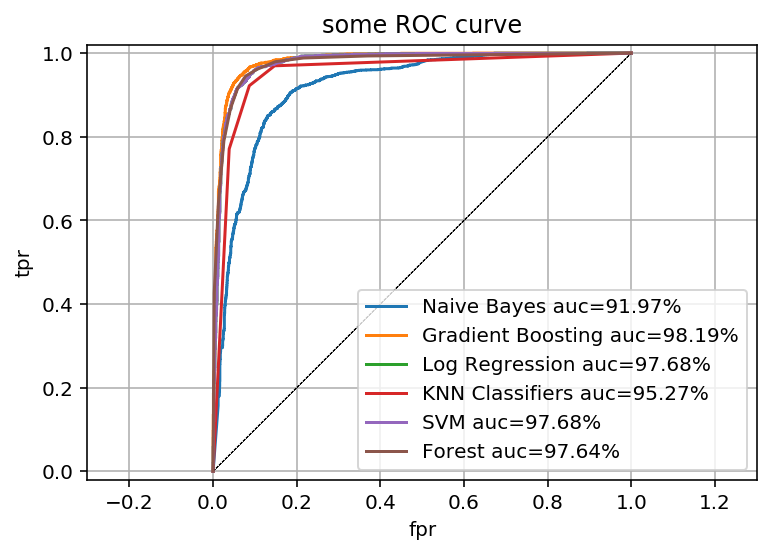

In [73]:
#insert 10
plot_roc(y_test, y_proba_NB, "Naive Bayes")
plot_roc(y_test, y_proba_GB, "Gradient Boosting")
plot_roc(y_test, y_proba_LR, "Log Regression")
plot_roc(y_test, y_proba_KNN,"KNN Classifiers")
plot_roc(y_test, y_proba_SVM,'SVM')
plot_roc(y_test, y_proba_Forest,'Forest')

In [0]:
X.iloc[100]

In [0]:
#insert 11
# using the one with the highest test score---Gradient Boositing
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
print(model.predict([[2711,0.3333,33,0,0,2,4,3325,3809,20540,0.374,29,0.24662,0.539472,0.2903,18477,0.880081,0.710443,11108,0.7627,0.921777,11367,0.827110,0.382295,0.372147,0.183538,0,1,1,1,1,1,1]]))

12.What are the worst schools? Some of them are chains of schools so don't necessarily consider singular names but generalize to chains. Give a lot of justification for your analysis as everyone might have a different answer here. Insert these responses into your blog.

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() # Scale the data to range 0-1
cols = ['instructional_expenditure_per_fte', 'retention','faculty_salary','7_yr_repayment_completion',
        '5_year_declining_balance', 'tuition_revenue_per_fte', 'pell_grant_debt']
X = df[cols]
X = scaler.fit_transform(X)
X = pd.DataFrame(X)
X.columns = cols

X[['name', 'for_profit']] = df[['name', 'for_profit']]
cols = X.columns.tolist()
X

In [0]:
# insert 12
cols = ['instructional_expenditure_per_fte', 'retention','faculty_salary','7_yr_repayment_completion',
        '5_year_declining_balance', 'tuition_revenue_per_fte', 'pell_grant_debt']
X = df[cols]
X = scaler.fit_transform(X)
X = pd.DataFrame(X)
X.columns = cols

X[['name', 'for_profit']] = df[['name', 'for_profit']]
cols = X.columns.tolist()

score = X['instructional_expenditure_per_fte']*(0.3)
score += X['retention'] * (0.2)
score += X['faculty_salary'] * (0.1)
score += X['7_yr_repayment_completion'] * (0.3)
score += X['5_year_declining_balance'] * (0.1)
score += X['tuition_revenue_per_fte'] * (-0.3)
score += X['pell_grant_debt'] * (-0.7)

X['school score'] = score
worst = X.nsmallest(10, 'school score')
worst
# !0 worst schools: Thuy Princess Beauty College, Total Look School of Cosmetology & Massage The..., Hair Academy of Safford, Strayer University-North Charlotte, South University-West Palm Beach, Strayer University-Cobb Campus, Citadel Military College of South Carolina, Hawaii Pacific University, and two schools with index of 2778, 755 that do not have name on it.

# For six of my variables that are highly related, I keep them in my dataset. Among six of them, four of them instructional expenditure, retention, faculty salary,7_year repayment completion, and 5_year declining balance are all positively related to the school score, which means the higher of the number, the better the schools are. The other two, tuition revenue and pell grant debt are negatively affect the school scores because students have to pay more and loan debt after they graduate.
# The porpotion of all positive factors and negative factors are made based on my personal opinion. The money the college spends on teaching and all equipments are the most important part for students to have good college studying experience; 7_year repayment is a way to examine whether students have bright futures after they graduate. For two negative factors, pell grant debt weighs much more than tuition revenue because many students are able to pay for the tuition and still own debt which is a more serious negative influence.

13.If you were a governmental organization overseeing accreditation, what factors would be most important to you in making sure that the college was non-predatory? Give a lot of detail here as well in your blog.

In [0]:
#insert 13
# Tuition is definetely the first priority for people to measure if the college is predatory or not. Lower annual tuition lead to a lower possibility that the school will gain profits from it. Also, instrumental expenditure is another important factor that contrasts the tuition. Those two factors should be higherly correlated. If the the tuition is high, it only makes sense if the school spends a lot of money on building a better environment for students to learn and enjoy, otherwise the school might be considered as predatory. It is important to find a balance between tuition and instrumental expenditure. In addition, the other factor that relates is the 7_year repayment, which shows the potential of students earning debts back later. Some students might loan debts right after they graduate, but with the education they've taknen, it is possible that they will earn money in a period of time.
# According to the article "Predatory loans and the schools that get poor students to take them", many schools advertise themselves, so students will borrow a lot of money and know that they are likely to get good jobs after they leave that will allow you to pay the loans back. However, it is more likely that the loans will not be back. As the Harvard Project on Predatory Student Lending explains, many shady for-profit colleges promise incredible job placement rates for graduates despite not being able to deliver. What colleges say is unreliable and sometimes misleading.
#(https://bigthink.com/politics-current-affairs/predatory-student-loans?rebelltitem=3#rebelltitem3)
# The Obama administration’s rules on for-profit colleges are based on two statistical measures of individual programs: how much money typical program graduates are required to spend on student loan payments every year, and how much they earn in the job market two years after graduation. If this “debt-to-earnings ratio” is too high for multiple years — if graduates need to spend too much of their income paying down loans — then the program is ruled ineligible to receive federal financial aid. It proves the first point, but in a more officil way 
#(https://www.nytimes.com/2017/01/13/upshot/harvard-too-obamas-final-push-to-catch-predatory-colleges-is-revealing.html)
# Also, checking some reference websites before choosing colleges is important.Use the education department’s College Scorecard or College Navigator tool for details on a schools' performance. The scorecard can show graduates’ salaries and how many students earn incomes that are above workers with only a high school diploma. These details are important because people want to attend a school only if they are confident that they will earn enough to make the program worthwhile.
#(https://www.nerdwallet.com/blog/loans/student-loans/college-choice/)

14.Read several articles on college predatory practices and cite and incorporate them into your blog discussion. Remember to link to them clearly by using the 
```[here](http://....)``` syntax.